In [1]:
import sys
from dataclasses import dataclass
from functools import partial
from typing import Sequence
from scipy.optimize import linear_sum_assignment as scipy_lsa
import matplotlib.pyplot as plt
import time
import pickle; import os

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand,
    lax
)
import keras as nn; nn.utils.set_random_seed(42)
import keras_cv as ncv

import tensorflow as tf; tf.random.set_seed(42)
import tensorflow_datasets as tfds

print('Python Version', sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

TEST = False
jax.disable_jit(disable=TEST)

Python Version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Keras Version 3.0.5 with jax backend 	Jax Version 0.4.23
Jax backend device gpu


# DETR and Training Arguments

In [2]:
class_ids = [    "no_object",    "Aeroplane",    "Bicycle",    "Bird",    "Boat",    "Bottle",    "Bus",
    "Car",    "Cat",    "Chair",    "Cow",    "Dining Table",    "Dog",    "Horse",    "Motorbike",
    "Person",    "Potted Plant",    "Sheep",    "Sofa",    "Train",    "Tv/monitor",
    ]

In [3]:
@dataclass
class config:
    # Object Detection Args
    N:int = 42 ### max(number of objects you want the model to be able to predict)
    image_size:tuple[int, int] = (500, 500)

    # Loss Args
    l1_weight:float = 5.0
    giou_weight:float = 2.0

    # Model hyperparameters
    ## Backbone and Transformer hyperparameters    
    d_model:int = 128
    num_layers:int = 6
    num_heads:int = 8
    assert d_model % num_heads == 0
    dff_in:int = 4*d_model
    dropout_rate:float = 0.1
    maxlen:Sequence[int] = (
        256, ### maximum(H1*W1) H1 and W1 image dimensions of output of conv_backbone
        N
    )
    ## FeedForward hyperparameters
    num_classes:int = len(class_ids)

    # Training Arguments
    num_grad_accumulation_steps:int = 2
    ## Optimizer
    num_steps:int = 7_000
    clipnorm:float = 0.1
    weight_decay:float = 1e-4
    ### Backbone Optimizer
    backbone_lr:float = 5e-5
    ### Transformer Optimizer
    transformer_lr:float = 5e-4

    ## General Args
    batch_size:int = 32 # mini batch_size if num_grad_accumulation_steps > 1
    patience:int = 5
    eval_steps:int = 100
    eval_freq:int = 300

config()

config(N=42, image_size=(500, 500), l1_weight=5.0, giou_weight=2.0, d_model=128, num_layers=6, num_heads=8, dff_in=512, dropout_rate=0.1, maxlen=(256, 42), num_classes=21, num_grad_accumulation_steps=2, num_steps=7000, clipnorm=0.1, weight_decay=0.0001, backbone_lr=5e-05, transformer_lr=0.0005, batch_size=32, patience=5, eval_steps=100, eval_freq=300)

# Dataset and Preprocessing

In [4]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], {"classes": inputs[1][0], "boxes": inputs[1][1]}
    ncv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.65,
        line_thickness=1,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = ncv.bounding_box.convert_format(
      inputs["objects"]["bbox"],
      images=image,
      source="rel_yxyx",
      target=bounding_box_format,
    )
    bounding_boxes = {
      "classes": tf.cast(inputs["objects"]["label"] + 1, dtype=tf.float32), # + 1 to incorparate no_object class
      "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

def load_pascal_voc(split, dataset, bounding_box_format):
    ds:tf.data.Dataset = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format), num_parallel_calls=tf.data.AUTOTUNE)
    return ds


train_data = load_pascal_voc(split="train", dataset="voc/2007", bounding_box_format="xywh")
val_data = load_pascal_voc(split="validation", dataset="voc/2007", bounding_box_format="xywh")
test_data = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

# first time download takes ~5.5mins
train_data = train_data.concatenate(test_data); del test_data
print("Number of Samples in")
print("\tTraining Dataset :", train_data.cardinality().numpy().tolist())
print("\tValidation Dataset :", val_data.cardinality().numpy().tolist())

Number of Samples in
	Training Dataset : 7453
	Validation Dataset : 2510


In [5]:
def preprocess(x):
    X = ncv.layers.Resizing(*config.image_size, bounding_box_format="xywh", pad_to_aspect_ratio=True)(x["images"])
    y = (
        tf.pad([x["bounding_boxes"]["classes"]], [[0,0], [config.N, config.N]])[0][config.N:-len(x["bounding_boxes"]["classes"])],
        tf.pad(x["bounding_boxes"]["boxes"], [[config.N, config.N], [0,0]])[config.N:-len(x["bounding_boxes"]["boxes"])]
    )
    return X, y

train_ds = train_data.map(lambda x: preprocess(x), num_parallel_calls=tf.data.AUTOTUNE)#.shuffle(6000)
val_ds = val_data.map(lambda x: preprocess(x), num_parallel_calls=tf.data.AUTOTUNE)#.shuffle(4000)

In [6]:
def normalize_bbox(x, y):
    img = x
    cls = y[0]
    box = y[1]/max(config.image_size)
    return img, (cls, box)

def denormalize_bbox(x, y):
    img = x
    cls = y[0]
    box = y[1]*max(config.image_size)
    return img, (cls, box)

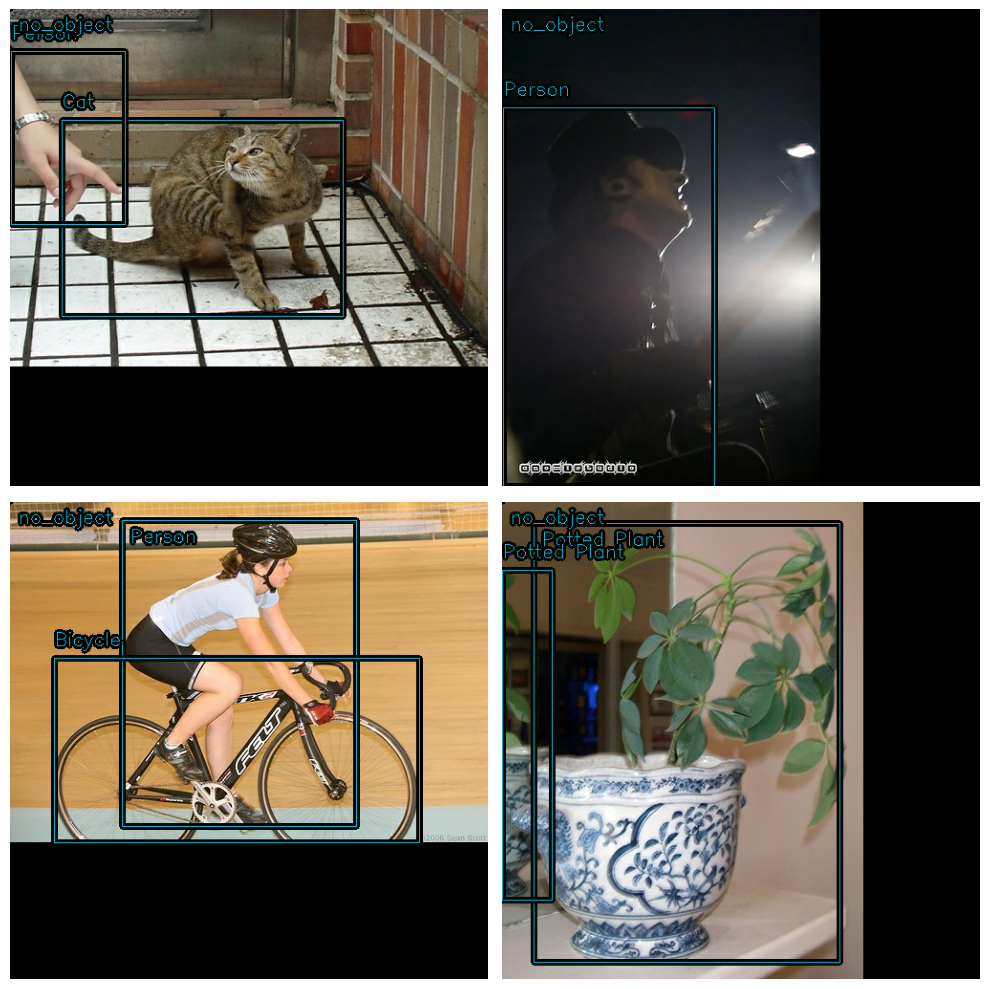

In [7]:
visualize_dataset(
    # Test normalize_bbox and denormalize_bbox
    train_ds.map(normalize_bbox).map(denormalize_bbox).ragged_batch(4, drop_remainder=True).shuffle(100), 
    bounding_box_format="xywh", 
    value_range=(0, 255), 
    rows=2, 
    cols=2
)

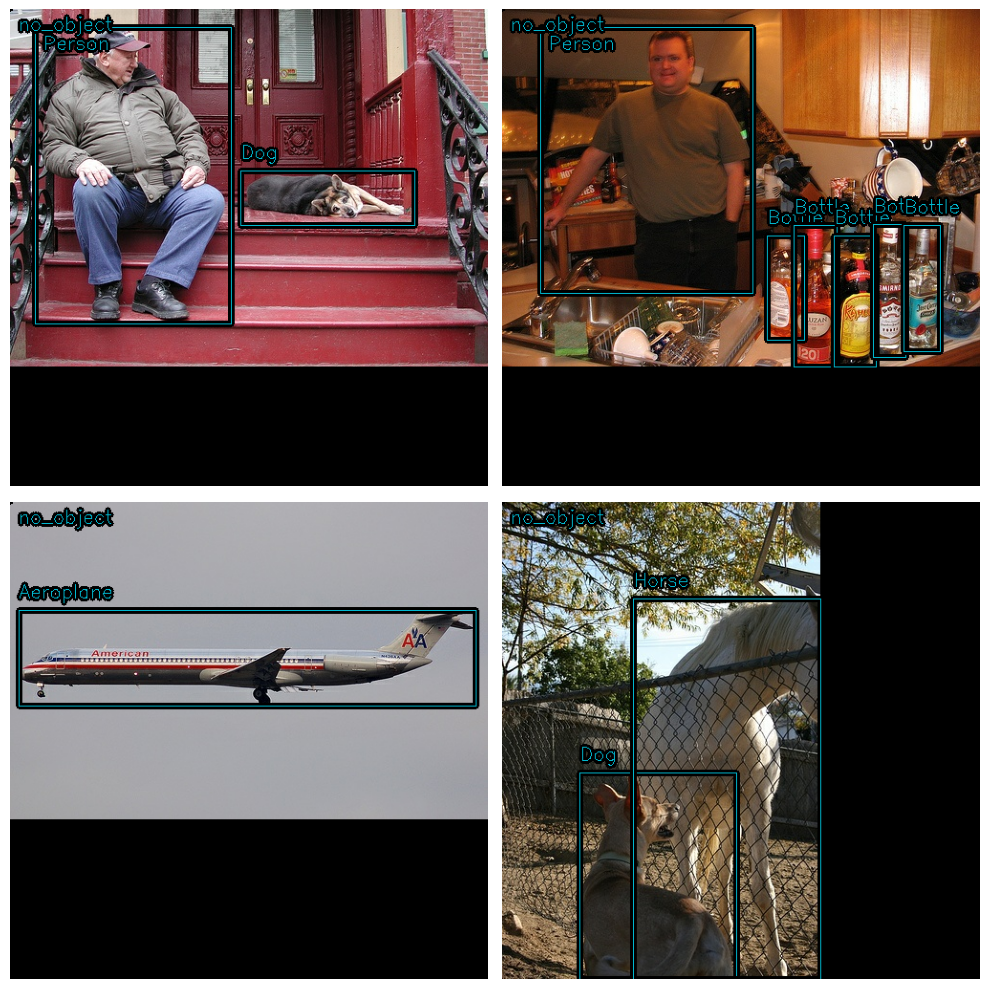

In [8]:
visualize_dataset(
    # Test normalize_bbox and denormalize_bbox
    val_ds.map(normalize_bbox).map(denormalize_bbox).ragged_batch(4, drop_remainder=True).shuffle(100), 
    bounding_box_format="xywh", 
    value_range=(0, 255), 
    rows=2, 
    cols=2
)

In [9]:
train_ds = train_ds.map(
    normalize_bbox
).batch(config.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(
    normalize_bbox
).batch(config.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).repeat().prefetch(tf.data.AUTOTUNE)

In [10]:
train_data_iter:tf.data.Iterator = iter(train_ds)
val_data_iter:tf.data.Iterator = iter(val_ds)

# Test Modules and get Module Summaries

In [11]:
def module_summary(
        module:nn.Model,
        input_shapes:Sequence[tuple], 
        output_shapes:Sequence[tuple]|None=None,
        only_build:bool=False,
        return_module:bool=False,
        print_model_output_shapes:bool=False
    ):
    randn_arr = lambda input_shapes: [jrand.uniform(jrand.PRNGKey(42), shape=shape) for shape in input_shapes]
    inputs = [
        randn_arr([shape])[0] if not isinstance(shape[0], (tuple, list)) else randn_arr(shape) for shape in input_shapes
    ]
    blablahh = module(*inputs, training=True)
    if only_build:
        return module
    blablahh:Sequence[Array] = (blablahh,) if not isinstance(blablahh, (list, tuple)) else blablahh

    print("-"*100)
    if print_model_output_shapes:
        print("printing model output shapes")
        for o in blablahh:
            print(o.shape)

    assert all([true_shape==pred.shape for true_shape, pred in  zip(output_shapes, blablahh)]), "Output shapes don't match. Investigate..."
    module.summary()
    print("-"*100)
    return module if return_module else None

# DETR CompOps

In [12]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: shape(1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs_shape(1, maxlen, 1, dim), cos_freqs_shape(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(repeats=2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(repeats=2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

In [13]:
class DETRTransformerAttSubBlock(nn.Model):
    """```
    Inputs:
        xq:Array   =shape=> shape(B, T|N, d_model)
        xkv:Array  =shape=> shape(B, T|N, d_model)
        qAdd:Array =shape=> shape(B, T|N, d_model)
        kAdd:Array =shape=> shape(B, T|N, d_model)
        training:bool
    Outputs:
        y:Array =shape=> shape(B, T|N, d_model)
    ```"""
    def __init__(self, config:config):
        super().__init__()                              # MLA In-out shapes EXAMPLE:
        self.att = nn.layers.MultiHeadAttention(        # q: (B, T, dim)
            num_heads=config.num_heads,                 # k: (B, N, dim)  =Output=> o: (B, T, dim) 
            key_dim=config.d_model//config.num_heads,   # v: (B, N, dim)
            dropout=config.dropout_rate
        )
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5)

    def call(self, xq:Array, xkv:Array, qAdd:Array, kAdd:Array, training:bool): # (B, T|N, d_model)
        z = self.att(xq + qAdd, xkv + kAdd, xkv, training=training) # (B, T|N, d_model)
        y = self.norm(xq) + z # (B, T|N, d_model)
        return y # (B, T|N, d_model)

########## Test ############
if TEST:
    module_summary(
        DETRTransformerAttSubBlock(config), 
        input_shapes=[(2, config.maxlen[0], config.d_model)]*4, 
        output_shapes=[(2, config.maxlen[0], config.d_model)]
    )
    module_summary(
        DETRTransformerAttSubBlock(config), 
        input_shapes=[(2, config.maxlen[1], config.d_model)]*4, 
        output_shapes=[(2, config.maxlen[1], config.d_model)]
    )

In [14]:
class DETRTransformerFeedForwardSubBlock(nn.Model):
    """```
    Inputs:
        x:Array =shape=> shape(B, T or N, d_model)
    Outputs:
        y:Array =shape=> shape(B, T or N, d_model)
    ```"""
    def __init__(self, config:config):
        super().__init__()
        self.ffn = nn.Sequential([
            nn.layers.Dense(config.dff_in, use_bias=True),
            nn.layers.Activation(nn.activations.relu),
            nn.layers.Dense(config.d_model, use_bias=True),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5)
    
    def call(self, x:Array, training:bool):
        z = self.ffn(x, training=training) # (B, T, d_model)
        y = self.norm(z) + x # (B, T, d_model)
        return y # (B, T, d_model)

########## Test ############
if TEST:
    module_summary(
        DETRTransformerFeedForwardSubBlock(config), 
        input_shapes=[(2, config.maxlen[0], config.d_model)]*1, 
        output_shapes=[(2, config.maxlen[0], config.d_model)]*1
    )
    module_summary(
        DETRTransformerFeedForwardSubBlock(config), 
        input_shapes=[(2, config.maxlen[1], config.d_model)]*1, 
        output_shapes=[(2, config.maxlen[1], config.d_model)]*1
    )

In [15]:
class DETRTransformerEncoderBlock(nn.Model):
    """```
    Inputs:
        xq:Array   => image_features    =shape=> shape(B, T, d_model)
        xkv:Array  => image_features    =shape=> shape(B, T, d_model)
        qAdd:Array => spatial_pos_embed =shape=> shape(B, T, d_model)
        kAdd:Array => spatial_pos_embed =shape=> shape(B, T, d_model)
        training:bool
    Outputs:
        y:Array =shape=> shape(B, T, d_model)
    ```"""
    def __init__(self, config:config):
        super().__init__()
        self.attsubblock = DETRTransformerAttSubBlock(config)
        self.ffn = DETRTransformerFeedForwardSubBlock(config)
                
    def call(
        self,
        xq:Array,
        xkv:Array,
        qAdd:Array,
        kAdd:Array,
        training:bool
    ):
        z = self.attsubblock(xq, xkv, qAdd, kAdd, training=training)
        y = self.ffn(z, training=training)
        return y
    
########## Test ############
if TEST:
    module_summary(
        DETRTransformerEncoderBlock(config), 
        input_shapes=[(2, config.maxlen[0], config.d_model)]*4, 
        output_shapes=[(2, config.maxlen[0], config.d_model)]*1
    )

In [16]:
class DETRTransformerDecoderBlock(nn.Model):
    """```
    Inputs:
        xq:Array         => decoder_output (object_queries initially) =shape=> shape(B, N, d_model)
        xkv:list[Array]  => [xq, encoder_output]                      =shape=> [shape(B, N, d_model), shape(B, T, d_model)]
        qAdd:list[Array] => [object_queries, object_queries]          =shape=> [shape(B, N, d_model), shape(B, N, d_model)]
        kAdd:list[Array] => [object_queries, spatial_pos_embed]       =shape=> [shape(B, N, d_model), shape(B, T, d_model)]
        training:bool
    Outputs:
        yq:Array => shape(B, N, d_model)
    ```"""
    def __init__(self, config:config):
        super().__init__()
        self.attsubblock1 = DETRTransformerAttSubBlock(config)
        self.attsubblock2 = DETRTransformerAttSubBlock(config)
        self.ffn = DETRTransformerFeedForwardSubBlock(config)

    def call(
        self,
        xq:Array, # shape(B, N, d_model)
        xkv:Sequence[Array],  # [xq, encoder_output]
        qAdd:Sequence[Array], # [object_queries, object_queries]
        kAdd:Sequence[Array], # [object_queries, spatial_pos_embed]
        training:bool
    ):
        zq = self.attsubblock1(xq, xkv[0], qAdd[0], kAdd[0], training=training)
        zq = self.attsubblock2(zq, xkv[1], qAdd[1], kAdd[1], training=training)
        yq = self.ffn(zq, training=training)
        return yq
    
########## Test ############
if TEST:
    module_summary(
        DETRTransformerDecoderBlock(config),
        input_shapes=
            [(2, config.maxlen[1], config.d_model),
            [(2, config.maxlen[1], config.d_model), (2, config.maxlen[0], config.d_model)],
            [(2, config.maxlen[1], config.d_model), (2, config.maxlen[1], config.d_model)],
            [(2, config.maxlen[1], config.d_model), (2, config.maxlen[0], config.d_model)]],
        output_shapes=[(2, config.maxlen[1], config.d_model)]
    )

![qq](images/image-1.png)

In [17]:
class DETRTransformer(nn.Model):
    def __init__(self, config:config, **kwargs):
        super().__init__(**kwargs)
        self.spatial_positional_encoding = PositionalEmbedding(
            config.maxlen[0], config.d_model
        ).sinusoidal_embeddings()[0] # (max_H*W=T, d_model)
        self.encoder_blocks = [
            DETRTransformerEncoderBlock(config) for _ in range(config.num_layers)
        ]

        self.object_queries = nn.layers.Embedding(config.maxlen[-1], config.d_model)(jnp.arange(config.maxlen[-1])) # (N, d_model)
        self.decoder_blocks = [
            DETRTransformerDecoderBlock(config) for _ in range(config.num_layers)
        ]

    def call(self, x:Array, training:bool): # (B, H*W=T, d_model)
        B, T = x.shape[:-1]

        spatial_positional_encoding = lax.broadcast(self.spatial_positional_encoding[:T], (B,)) # (B, T, d_model) <== (max_H*W, d_model)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(
                xq=x, xkv=x, qAdd=spatial_positional_encoding, kAdd=spatial_positional_encoding, training=training) # (B, T, d_model)
        encoder_output = x # (B, T, d_model)

        object_queries = lax.broadcast(self.object_queries, (B,)) # (B, N, d_model)
        x = object_queries
        for decoder_block in self.decoder_blocks:
            x = decoder_block(
                xq=x, xkv=[x, encoder_output], 
                qAdd=[object_queries, object_queries], kAdd=[object_queries, spatial_positional_encoding],
                training=training
            )
        return x # (B, N, d_model)
    
########## Test ############
if TEST:
    module_summary(
        DETRTransformer(config),
        input_shapes=[(2, config.maxlen[0], config.d_model)]*1,
        output_shapes=[(2, config.maxlen[1], config.d_model)]*1
    )

# Loss CompOps

In [18]:
giou = ncv.losses.GIoULoss(bounding_box_format="xyWH")
mae = nn.losses.MeanAbsoluteError()
cross_entropy = nn.losses.SparseCategoricalCrossentropy(from_logits=False)

def BoxLoss(bbox_true:Array, bbox_pred:Array, lambda_giou:float=1., lambda_l1:float=1.):
    giou_loss = lambda_giou*giou(bbox_true, bbox_pred)
    l1_loss = lambda_l1*mae(bbox_true, bbox_pred)
    return giou_loss + l1_loss

def ClassLoss(class_true:Array, class_prob:Array, down_weight_no_object_class:bool=False):
    sample_weight = jnp.where(class_true==0, 0.1, 1.) if down_weight_no_object_class else None # downsample no_object class by 10% if True
    return cross_entropy(class_true, class_prob, sample_weight=sample_weight) # -logprob(class_true * sample_weight)

# Matcher

In [19]:
class Matcher:
    def __init__(self, vmaped:bool=True):
        self.vmaped:bool = vmaped

    @staticmethod
    @jax.jit
    def MatchLoss(class_true:Array, class_prob:Array, bbox_true:Array, bbox_pred:Array):
        """```
        Inouts:
            class_true:Array => shape(,)
            class_prob:Array => shape(,)
            bbox_true:Array => shape(4,)
            bbox_pred:Array => shape(4,)
        Outputs:
            match_loss:Array => shape(,)
        ```"""
        class_bool = (class_true!=0).astype(float) # int(not class_true==0)
        # class_true = no_object = 0 => int(not True) = 0
        # class_true != no_object != 0 => int(not False) = 1
        
        match_loss = -class_bool*class_prob + class_bool*BoxLoss(bbox_true[None], bbox_pred[None])
        return match_loss
    
    @staticmethod
    @jax.jit
    def compute_unbatched_cost_matrix(class_true:Array, class_prob:Array, bbox_true:Array, bbox_pred:Array):
        """```
        Inputs:
            class_true:Array => shape(N,)
            class_prob:Array => shape(N, num_classes)
            bbox_true:Array => shape(N, 4)
            bbox_pred:Array => shape(N, 4)
        Outputs:
            unbatched_cost:Array => shape(N, N)
        ```"""
        N = class_true.shape[0]
        cost_i = lambda i: jax.vmap(lambda j: Matcher.MatchLoss(
            class_true[i],
            class_prob[j, class_true[i].astype(int)],
            bbox_true[i],
            bbox_pred[j]
        ), in_axes=0, out_axes=0)(jnp.arange(N))
        unbatched_cost = jax.vmap(lambda i: cost_i(i), in_axes=0, out_axes=0)(jnp.arange(N))
        return unbatched_cost # (N, N)
    
    @staticmethod
    @jax.jit
    def compute_batched_cost_matrix(class_true:Array, class_prob:Array, bbox_true:Array, bbox_pred:Array):
        """```
        Inputs:
            class_true:Array => shape(B, N)
            class_prob:Array => shape(B, N, num_classes)
            bbox_true:Array => shape(B, N, 4)
            bbox_pred:Array => shape(B, N, 4)
        Outputs:
            C:Array => shape(B, N, N)
        ```"""
        batch_size = class_true.shape[0]
        C = jax.vmap(lambda B: Matcher.compute_unbatched_cost_matrix(
            class_true[B], class_prob[B], bbox_true[B], bbox_pred[B]
        ), in_axes=0, out_axes=0)(jnp.arange(batch_size))
        return C # (B, N, N)
    
    @staticmethod
    @jax.jit
    def unvmaped_compute_batched_cost_matrix(class_true:Array, class_prob:Array, bbox_true:Array, bbox_pred:Array):
        """```
        Inputs:
            class_true:Array => shape(B, N)
            class_prob:Array => shape(B, N, num_classes)
            bbox_true:Array => shape(B, N, 4)
            bbox_pred:Array => shape(B, N, 4)
        ```"""
        N = class_true.shape[1]
        batch_size = len(class_true)
        C = jnp.zeros((batch_size, N, N))
        for b in range(batch_size):
            for i in range(N):
                for j in range(N):
                    C = C.at[b, i, j].set(
                        Matcher.MatchLoss(
                            class_true[b][i], 
                            class_prob[b][j, class_true[b][i].astype(int)], 
                            bbox_true[b][i],
                            bbox_pred[b][j]
                        )
                    )
        return C

    @staticmethod
    # Cannot jit this function as linear_sum_assignment is used which is a numpy function not a jax function
    def match(class_true:Array, class_prob:Array, bbox_true:Array, bbox_pred:Array, vmaped:bool=True):
        """```
        Inputs:
            class_true:Array => shape(B, N)
            class_prob:Array => shape(B, N, num_classes)
            bbox_true:Array => shape(B, N, 4)
            bbox_pred:Array => shape(B, N, 4)
        Outputs:
            matched_class_prob:Array => shape(B, N, num_classes)
            matched_bbox_pred:Array => shape(B, N, 4)
        ```"""
        C:Array = Matcher.compute_batched_cost_matrix( # (B, N, N)
                    class_true, class_prob, bbox_true, bbox_pred
                ) if vmaped else Matcher.unvmaped_compute_batched_cost_matrix(
                    class_true, class_prob, bbox_true, bbox_pred
                )
        to_indices = jnp.stack(list(map(lambda Cb: scipy_lsa(Cb)[1], C)))[..., None] # (B, N, 1)

        matched_class_prob = jnp.take_along_axis(class_prob, to_indices, axis=1) # (B, N, num_classes)
        matched_bbox_pred = jnp.take_along_axis(bbox_pred, to_indices, axis=1)   # (B, N, 4)
        return matched_class_prob, matched_bbox_pred # (B, N, num_classes), (B, N, 4)
    
    def __call__(self, y_true:Sequence[Array], y_pred:Sequence[Array]):
        (class_true, bbox_true), (class_prob, bbox_pred) = y_true, y_pred
        (class_true, bbox_true) = lax.stop_gradient(class_true.astype(int)), lax.stop_gradient(bbox_true)
        (class_prob, bbox_pred) = lax.stop_gradient(class_prob), lax.stop_gradient(bbox_pred)

        y_matched_pred = Matcher.match(class_true, class_prob, bbox_true, bbox_pred, vmaped=self.vmaped)
        return y_matched_pred

# Hungarian Loss

In [20]:
class HungarianLoss(nn.Loss):
    """```
        Inputs:
            y_true:
                class_true:Array => shape(B, N)
                bbox_true:Array => shape(B, N, 4)
            y_pred:
                class_prob:Array => shape(B, N, num_classes)
                bbox_pred:Array => shape(B, N, 4)
        Outputs:
            loss: Array
    ```"""
    def __init__(self, l1_weight:float, giou_weight:float):
        super().__init__()
        self.l1_weight = l1_weight
        self.giou_weight = giou_weight
    
    @partial(jax.jit, static_argnums=0)
    def compute_loss(self, y_true:tuple[Array, Array], y_pred:tuple[Array, Array]):
        class_true, bbox_true = y_true
        class_prob, bbox_pred = y_pred

        class_loss = ClassLoss(class_true, class_prob, down_weight_no_object_class=True) # (B, N), (B, N, num_classes)
        box_loss = BoxLoss(bbox_true, bbox_pred, self.giou_weight, self.l1_weight)
        loss = class_loss + box_loss
        return loss
    
    def call(self, y_true:tuple[Array, Array], y_pred:tuple[Array, Array]):
        return self.compute_loss(y_true, y_pred)

## Test Matcher with Loss Function

In [21]:
########## Test ############
def test_matcher_and_lossfn(rand:bool=False, print_it:bool=False):
    class_true, bbox_true = next(val_data_iter)[1]
    class_true, bbox_true = jnp.array(class_true), jnp.array(bbox_true)
    if rand:
        class_prob = jrand.uniform(jrand.PRNGKey(42), shape=(*class_true.shape, config.num_classes))
        bbox_pred = jrand.uniform(jrand.PRNGKey(42), shape=bbox_true.shape)
        class_pred = class_prob.argmax(-1)
    else:
        class_pred = jrand.permutation(jrand.PRNGKey(42), class_true, axis=1); atol=1e-3
        bbox_pred = (jrand.permutation(jrand.PRNGKey(42), bbox_true, axis=1)+atol).clip(min=0, max=1)
        class_prob = jax.nn.softmax(jax.nn.one_hot(class_pred, config.num_classes)+2)
        assert (class_prob.argmax(-1)==class_pred).all()
    
    t0 = time.time()
    mcls, mbbox = Matcher(vmaped=True)(y_true=(class_true, bbox_true), y_pred=(class_prob, bbox_pred))
    t1 = time.time(); dt = t1-t0
    print(f"\tTiming with batch_size {config.batch_size}: {(dt)*1000:.2f}ms or {(dt):.4f}s")
    print(f"\tTiming per batch_size: {(dt/config.batch_size)*1000:.2f}ms")

    def print_test_cases():
        print("class_pred", class_pred, sep="\n") # (B, 42)
        print("bbox_pred", bbox_pred, sep="\n")   # (B, 42, 4)
        print("class_true", class_true, sep="\n") # (B, 42)
        print("matched_class_pred", mcls.argmax(-1), sep="\n")
        print("matched_bbox_pred", mbbox, sep="\n")
        print("bbox_true", bbox_true, sep="\n")   # (B, 42, 4)
    if print_it:
        print_test_cases()
    if not rand:
        try:
            max_diff = round((mbbox-bbox_true).max(), 4)
            assert (mcls.argmax(-1)==class_true).all(), "Problem in Matching Classes"
            assert max_diff<=(atol), f"Problem in Matching Bounding Boxes max_diff: {max_diff} atol: {atol}"
        except:
            print("Problem in matching. Investigate...")
            print_test_cases()
            assert False

    print(
        "\tLoss without matching:",
        HungarianLoss(config.l1_weight, config.giou_weight)(
            y_true=(class_true, bbox_true), y_pred=(class_prob, bbox_pred)
        ), end="\n\t"
    )
    print(
        "Loss with matching:",
        HungarianLoss(config.l1_weight, config.giou_weight)(
            y_true=(class_true, bbox_true), y_pred=(mcls, mbbox)
        )
    )
    return


if TEST:
    print("First call:")
    test_matcher_and_lossfn(rand=False)
    print("\n\nSubsequent calls:")
    test_matcher_and_lossfn(rand=False)
    test_matcher_and_lossfn(rand=False)
    print("\n\ncalls on random predictions:")
    test_matcher_and_lossfn(rand=True)
    test_matcher_and_lossfn(rand=True)

In [22]:
########## Test ############ ==> (custom inputs)
def test_matcher_with_lossfn(print_it:bool=False):
    # possible classes = [0, 1, 2]
    class_true = jnp.array([[1, 2, 0], 
                            [2, 1, 0]])
    print(f"\tclass_true, {class_true.shape}") if print_it else print("", end="") # (B, N)
    class_pred = jnp.array([[1, 0, 2], 
                            [0, 1, 2]])
    print(f"\tclass_pred {class_pred.shape}") if print_it else print("", end="") # (B, N)
    N = class_true.shape[-1]

    class_prob = jnp.array([[[0.1, 0.8, 0.1], # (B, N, n_classes)
                            [0.8, 0.0, 0.2],
                            [0.1, 0.0, 0.9]],
                        [[0.9, 0.0, 0.1],
                            [0.4, 0.5, 0.1],
                            [0.3, 0.1, 0.6]]], dtype=jnp.float32)
    print(f"\tclass_prob {class_prob.shape}") if print_it else print("", end="")
    bbox_true = jnp.array([[[0.2, 0.1, 0.6, 0.9],           # 1
                        [0.1, 0.4, 0.5, 0.6],            # 2
                        [0.0, 0.0, 0.0, 0.0]],           # 0
                        [[0.1, 0.6, 0.5, 0.2],        # 2
                            [0.1, 0.3, 0.5, 0.4],        # 1
                            [0.0, 0.0, 0.0, 0.0]]],      # 0
                                dtype=jnp.float32) # (B, N, 4)
    print(f"\tbbox_true {bbox_true.shape}") if print_it else print("", end="")
    bbox_pred = jnp.array([[[0.198, 0.1, 0.601, 0.91],                           # 1
                        [0.01, 0.009, 0.001, 0.0],                            # 0
                        [0.101, 0.39, 0.501, 0.601]],                         # 2
                        [[0.01, 0.009, 0.001, 0.0],                    # 0
                        [0.11, 0.298, 0.499, 0.39],                   # 1
                        [0.11, 0.62, 0.501, 0.2009]]],                # 2
                                dtype=jnp.float32) # (B, N, 4)
    print(f"\tbbox_pred {bbox_pred.shape}") if print_it else print("", end="")

    print("\n\tmaximum number of onbjects that can be detected is", N) if print_it else print("", end="")
    print("\tunique classes", jnp.unique(class_true), end="\n\n") if print_it else print("", end="")

    t0 = time.time()
    matched_class_prob1, matched_bbox_pred1 = Matcher(vmaped=False)(y_true=(class_true, bbox_true), y_pred=(class_prob, bbox_pred))
    t1 = time.time()
    matched_class_prob, matched_bbox_pred = Matcher(vmaped=True)(y_true=(class_true, bbox_true), y_pred=(class_prob, bbox_pred))
    t2 = time.time()
    assert all(
        [jnp.allclose(matched_class_prob1,matched_class_prob), jnp.allclose(matched_bbox_pred1, matched_bbox_pred)]
    ), "Vmaped and unvmaped versions don't match. Investigate..."
    print(f"\tUnvmaped Timing: {(t1-t0)*1000:.2f}ms")
    print(f"\tVmaped   Timing: {(t2-t1)*1000:.2f}ms\n")

    print(
        "\tLoss without matching:",
        HungarianLoss(config.l1_weight, config.giou_weight)(
            y_true=(class_true, bbox_true), y_pred=(class_prob, bbox_pred)
        ), end="\n"
    )
    print(
        "\tLoss with matching:",
        HungarianLoss(config.l1_weight, config.giou_weight)(
            y_true=(class_true, bbox_true), y_pred=(matched_class_prob, matched_bbox_pred)
        )
    )
    return

if TEST:
    print("First call:")
    test_matcher_with_lossfn()
    print("\nSubsequent calls:")
    test_matcher_with_lossfn()
    test_matcher_with_lossfn()

# DETR

In [23]:
class DETR(nn.Model):
    def __init__(self, config:config):
        super().__init__()
        # Convolutional backbone
        self.conv_backbone = nn.applications.MobileNetV3Large( # MobileNetV3Small, MobileNetV3Large
                input_shape=(*config.image_size, 3),
                include_top=False,
                include_preprocessing=True # includes rescaling
            )
        self.conv = nn.layers.Conv2D(config.d_model, kernel_size=(1, 1))
        
        # Transformer
        self.transformer = DETRTransformer(config, name="detr_transformer")
        # FeedForward
        self.linear_class, self.linear_bbox = (
            nn.layers.Dense(config.num_classes, name="linear_class"), 
            nn.layers.Dense(4, name="linear_bbox")
        )

    def call(self, x:Array, training:bool=True):
        # x = self.process_input(x) # (B, H, W, 3)
        x = self.conv_backbone(x, training=False) # (B, H1, W1, C_out) # training=False freeze batchnorm layers
        x = self.conv(x) # (B, H1, W1, d_model)
        x = lax.collapse(x, start_dimension=1, stop_dimension=3) # (B, T=H1*W1, d_model)

        x = self.transformer(x, training=training) # (B, N, d_model) <= (B, T, d_model)
        
        class_probs, bbox_pred = (
            jax.nn.softmax(self.linear_class(x), axis=-1),
            jax.nn.sigmoid(self.linear_bbox(x))
        )
        return class_probs, bbox_pred # (B, N, num_classes), (B, N, 4)

In [24]:
model = module_summary(
    DETR(config),
    input_shapes=[(2, *config.image_size, 3)],
    output_shapes=[(2, config.maxlen[1], config.num_classes), (2, config.maxlen[1], 4)],
    return_module=True
)

/home/vvy/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


----------------------------------------------------------------------------------------------------


Model: "detr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ ?                      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detr_transformer                │ ?                      │     2,777,088 │
│ (DETRTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_class (Dense)            │ ?                      │         2,709 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_bbox (Dense)             │ ?                      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,899,673 (22.51 MB)

 Trainable params: 5,875,273 (22.41 MB)

 Non-trainable params: 24,400 (95.31 KB)

----------------------------------------------------------------------------------------------------


In [25]:
print(model.trainable_variables,)
NUM_TRAINABLE_BACKBONE_VARS = len([var.path for var in model.trainable_variables if ("detr" not in var.path)])
NUM_TRAINABLE_BACKBONE_VARS

170

# Save Model and Weights

In [26]:
def save_model_weights(dir_suffix:str, model:nn.Model|None, train_state:Sequence[list]|None = None):
    """
    dir_suffix: directory and suffix separated by "|" 
    model: keras model
    train_state: (trainable_vars, non_traininable_vars)
    """
    assert any([model, train_state]), "provide atleast any one, model or training state"

    dir, suffix = dir_suffix.split("|"); path = os.path.join(dir, "".join([suffix, ".model"]))
    obj = [model, train_state]
    os.makedirs(name=path, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

In [27]:
def load_model_weights(path:str):
    with open(path, "rb") as file:
        model, train_state = pickle.load(file)
    return model, train_state

# Essentials: Loss Function, Optimizer, Matcher

In [28]:
backbone_optimizer = nn.optimizers.AdamW(
    learning_rate=config.backbone_lr,
    weight_decay=config.weight_decay,
    clipnorm=config.clipnorm
)
rest_optimizer = nn.optimizers.AdamW(
    learning_rate=config.transformer_lr,
    weight_decay=config.weight_decay,
    clipnorm=config.clipnorm
)

loss_fn = HungarianLoss(
    l1_weight=config.l1_weight,
    giou_weight=config.giou_weight
)
match_true_predicted = Matcher()

# Training Loop

In [29]:
@jax.jit
def model_call(trainable_vars:list, non_trainable_vars:list, X_batch:list):
    y_pred, non_trainable_vars = model.stateless_call(trainable_vars, non_trainable_vars, X_batch)
    return y_pred, non_trainable_vars

def optimizer_apply(optimizer:nn.optimizers.AdamW, optimizer_vars:list, grads:Sequence, trainable_vars:list):
    trainable_vars, optimizer_vars = optimizer.stateless_apply(
        optimizer_vars, grads, trainable_vars
    )
    return trainable_vars, optimizer_vars

backbone_opt_apply = jax.jit(partial(optimizer_apply, optimizer=backbone_optimizer))
rest_opt_apply = jax.jit(partial(optimizer_apply, optimizer=rest_optimizer))

# has a numpy function in it (in the matcher), can't jit this function. So we jit individual comps
def compute_loss(trainable_vars:list, non_trainable_vars:list, X_batch:Array, y_batch:Sequence[Array], num_grad_accumulation_steps:int=1):
    y_pred, non_trainable_vars = model_call(trainable_vars, non_trainable_vars, X_batch)
    y_pred_matched = match_true_predicted(y_batch, y_pred) # has lax.stop_gradient, so no problem to grad the function `compute_loss_and_updates`
    scaled_loss = loss_fn(y_batch, y_pred_matched)/num_grad_accumulation_steps
    return scaled_loss, non_trainable_vars

# has a numpy function in it (in the matcher), can't jit this function
grad_fn = jax.value_and_grad(compute_loss, has_aux=True, argnums=0) # returns ∂(loss)/∂(trainable_vars)

def evaluate(train_states:list[list]):
    mean_losses = []
    for eval_batch_iter in [train_data_iter, val_data_iter]:
        losses = jnp.zeros(config.eval_steps)

        for eval_step in range(config.eval_steps):
            X_batch, y_batch = next(eval_batch_iter)
            loss, train_states[1] = compute_loss(
                *train_states, 
                jnp.array(X_batch), 
                [jnp.array(yi) for yi in y_batch]
            )
            losses = losses.at[eval_step].set(loss)
        mean_losses.append(losses.mean())
    return mean_losses # [train_loss, val_loss]

In [30]:
def train(return_best_train_states:bool):
    # https://github.com/keras-team/keras/issues/18857#issuecomment-1834534462
    trainable_vars = model.trainable_variables

    backbone_optimizer.build(trainable_vars[:NUM_TRAINABLE_BACKBONE_VARS])
    rest_optimizer.build(trainable_vars[NUM_TRAINABLE_BACKBONE_VARS:])

    trainable_vars = [trainable_var.value for trainable_var in model.trainable_variables]
    non_trainable_vars = model.non_trainable_variables
    backbone_opt_vars, rest_opt_vars = backbone_optimizer.variables, rest_optimizer.variables

    training_losses = {"Training Losses":[]}; best_val_loss = 1e8
    best_train_states = [trainable_vars, non_trainable_vars]

    t0 = time.time(); step = 1; wait = 0
    print("Traning started...")
    X_batch, y_batch = next(train_data_iter)
    while True:
        # condition to terminate
        if step>config.num_steps or wait>config.patience:
            print(f"Early Stopping at Step {step}." if wait > config.patience else "Training Terminated.")
            break
        
        # train model
        if config.num_grad_accumulation_steps > 1:
            ## accumulate gradients to be added
            grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_vars)
            for _ in range(config.num_grad_accumulation_steps):
                (scaled_loss, non_trainable_vars), grad = grad_fn(
                    trainable_vars, non_trainable_vars,
                    jnp.array(X_batch), [jnp.array(yi) for yi in y_batch],
                    config.num_grad_accumulation_steps
                )
                X_batch, y_batch = next(train_data_iter)
                grads = jax.tree_util.tree_map(
                    lambda g1, g2: jnp.add(g1, g2), grads, grad # sum grads for grad accumation
                )
            grad = None # save memory
            loss = scaled_loss*config.num_grad_accumulation_steps
        else:
            (loss, non_trainable_vars), grads = grad_fn(
                    trainable_vars, non_trainable_vars,
                    jnp.array(X_batch), [jnp.array(yi) for yi in y_batch]
                )
            X_batch, y_batch = next(train_data_iter)
        
        trainable_vars[:NUM_TRAINABLE_BACKBONE_VARS], backbone_opt_vars = backbone_opt_apply(
            optimizer_vars=backbone_opt_vars,
            grads=grads[:NUM_TRAINABLE_BACKBONE_VARS],
            trainable_vars=trainable_vars[:NUM_TRAINABLE_BACKBONE_VARS]
        )
        trainable_vars[NUM_TRAINABLE_BACKBONE_VARS:], rest_opt_vars = rest_opt_apply(
            optimizer_vars=rest_opt_vars,
            grads=grads[NUM_TRAINABLE_BACKBONE_VARS:],
            trainable_vars=trainable_vars[NUM_TRAINABLE_BACKBONE_VARS:]
        )
        grads = None # save memory
        
        training_losses["Training Losses"].append(loss.tolist())
        if step % config.eval_freq == 0:
            print("Evaluating...")
            [eval_train_loss, eval_val_loss] = evaluate([trainable_vars, non_trainable_vars])
            print(f"\t| Training Loss: {eval_train_loss:.4f} || Validation Loss: {eval_val_loss:.4f} |")

            if eval_val_loss < best_val_loss:
                best_val_loss = eval_val_loss
                best_train_states = [trainable_vars, non_trainable_vars]
                best_step = step
                wait = 0
            else:
                wait += 1
        
        # calculate time
        t1 = time.time()
        dt = t1-t0; t0=t1

        # print the essentials
        print(f"| Step: {step} || Loss: {loss:.4f} || dt: {dt*1000:.2f}ms |")
        step += 1

    if return_best_train_states:
        print(f"Best Weights are from step {best_step} with an estimated validation loss of {best_val_loss:.4f}")
        return best_train_states, training_losses

    return (trainable_vars, non_trainable_vars), training_losses

In [31]:
train_states, losses = train(return_best_train_states=True)

Traning started...
| Step: 1 || Loss: 6.7780 || dt: 26272.99ms |
| Step: 2 || Loss: 6.8693 || dt: 404.72ms |
| Step: 3 || Loss: 6.8371 || dt: 356.41ms |
| Step: 4 || Loss: 6.8240 || dt: 362.05ms |
| Step: 5 || Loss: 6.8306 || dt: 653.09ms |
| Step: 6 || Loss: 6.8137 || dt: 364.47ms |
| Step: 7 || Loss: 6.9105 || dt: 362.19ms |
| Step: 8 || Loss: 6.9931 || dt: 360.67ms |
| Step: 9 || Loss: 6.8897 || dt: 391.04ms |
| Step: 10 || Loss: 6.7373 || dt: 412.34ms |
| Step: 11 || Loss: 6.7612 || dt: 366.08ms |
| Step: 12 || Loss: 7.0412 || dt: 365.90ms |
| Step: 13 || Loss: 6.8695 || dt: 363.75ms |
| Step: 14 || Loss: 6.8269 || dt: 375.20ms |
| Step: 15 || Loss: 6.8296 || dt: 376.76ms |
| Step: 16 || Loss: 6.8652 || dt: 379.85ms |
| Step: 17 || Loss: 6.9020 || dt: 362.00ms |
| Step: 18 || Loss: 6.8546 || dt: 363.46ms |
| Step: 19 || Loss: 6.8444 || dt: 626.25ms |
| Step: 20 || Loss: 6.8271 || dt: 364.51ms |
| Step: 21 || Loss: 6.8834 || dt: 374.05ms |
| Step: 22 || Loss: 6.9243 || dt: 372.25ms 

# Loss Vs LR and Test Training

```python
def LossVsLr_TestTraining(log10lr_range:tuple[float, float]):
    model = module_summary(DETR(config), input_shapes=[(2, 500, 500, 3)], only_build=True)
    model_call = jax.jit(model.stateless_call)
    optimizer_lr = lambda lr: nn.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=config.weight_decay
    )
    loss_fn = HungarianLoss(
        l1_weight=config.l1_weight, 
        giou_weight=config.giou_weight
    )
    match_true_predicted = Matcher()
    
    def trainStep(lr:float, state:Sequence[list], X_batch:Array, y_batch:Sequence[Array]):
        [trainable_vars, non_trainable_vars] = state
        optimizer = optimizer_lr(lr)
        optimizer.build(model.trainable_variables)
        optimizer_vars = optimizer.variables

        def compute_loss(trainable_vars:list, non_trainable_vars:list, X_batch:Array, y_batch:Sequence[Array]):
            y_pred, non_trainable_vars = model_call(trainable_vars, non_trainable_vars, X_batch)
            y_pred_matched = match_true_predicted(y_batch, y_pred)
            loss = loss_fn(y_batch, y_pred_matched)
            return loss, non_trainable_vars
        grad_fn = jax.value_and_grad(compute_loss, has_aux=True, argnums=0)
        
        (loss, non_trainable_vars), grads = grad_fn(trainable_vars, non_trainable_vars, X_batch, y_batch)
        trainable_vars, optimizer_vars = optimizer.stateless_apply(optimizer_vars, grads, trainable_vars)
        state = [trainable_vars, non_trainable_vars]
        return loss, state
    
    lrs = (10**jnp.linspace(log10lr_range[0], log10lr_range[1], 100)).tolist()
    losses = []
    state = (model.trainable_variables, model.non_trainable_variables)
    x, y = next(testing_iter); x, y = jnp.array(x), [jnp.array(yi) for yi in y]
    t0 = time.time()
    for step, lr in enumerate(lrs):
        loss, state = trainStep(lr, state, x, y)
        t1 = time.time(); losses.append(loss)
        print(f"| Step: {step+1} | Loss: {loss:.4f} | LR: {lr:e} | Time: {(t1-t0)*1000:.2f}ms |")
        t0=t1
    return lrs, losses

lrs, losses = LossVsLr_TestTraining((-6, -2))

plt.figure(figsize=(15,5))
plt.xlabel("Log base10 Learning Rate: Do 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.0, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lrs)).tolist(), losses)
plt.show()
```

```python
# @jax.jit           # (B, N)         (B, N, num_classes)
def get_accuracy(class_true:Array, matched_class_prob:Array):
    matched_class_pred = matched_class_prob.argmax(-1) # (B, N)
    batch_accuracy = (class_true==matched_class_pred).sum(-1)/class_true.shape[-1] # (B,)
    return batch_accuracy.mean() # (,)
```